# 1. Sobel mask를 통한 edge 영상을 획득한 후 정제된 edge 출력하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**2D 컨볼루션을 수행하는 함수 정의**

In [2]:
def convolve2d(image, kernel):
    # Get dimensions of image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate padding dimensions
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Initialize output array
    output = np.zeros_like(image)

    # Convolve
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output

**Non-maximum suppression (NMS) 알고리즘 구현**

In [3]:
def non_max_suppression(img, D):
    M, N = img.shape
    output = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # 각도에 따른 픽셀 값 비교
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif 22.5 <= angle[i,j] < 67.5:
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif 67.5 <= angle[i,j] < 112.5:
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif 112.5 <= angle[i,j] < 157.5:
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                # 지역 최대값 판별
                if (img[i,j] >= q) and (img[i,j] >= r):
                    output[i,j] = img[i,j]
                else:
                    output[i,j] = 0

            except IndexError as e:
                pass

    return output

**이중 임계값(Hysteresis Thresholding) 구현**

In [4]:
def hysteresis_threshold(img, low, high):
    M, N = img.shape
    output = np.zeros((M,N), dtype=np.int32)

    strong = 255
    weak = 50

    strong_i, strong_j = np.where(img >= high)
    zeros_i, zeros_j = np.where(img < low)

    weak_i, weak_j = np.where((img <= high) & (img >= low))

    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (output[i,j] == weak):
                try:
                    if ((output[i+1, j-1] == strong) or (output[i+1, j] == strong) or (output[i+1, j+1] == strong)
                        or (output[i, j-1] == strong) or (output[i, j+1] == strong)
                        or (output[i-1, j-1] == strong) or (output[i-1, j] == strong) or (output[i-1, j+1] == strong)):
                        output[i, j] = strong
                    else:
                        output[i, j] = 0
                except IndexError as e:
                    pass

    return output

**1) Sobel mask를 적용하여 얻은 edge 영상 획득**  
**2) 획득한 edge 영상에 대해 Non-maximal suppression을 수행**

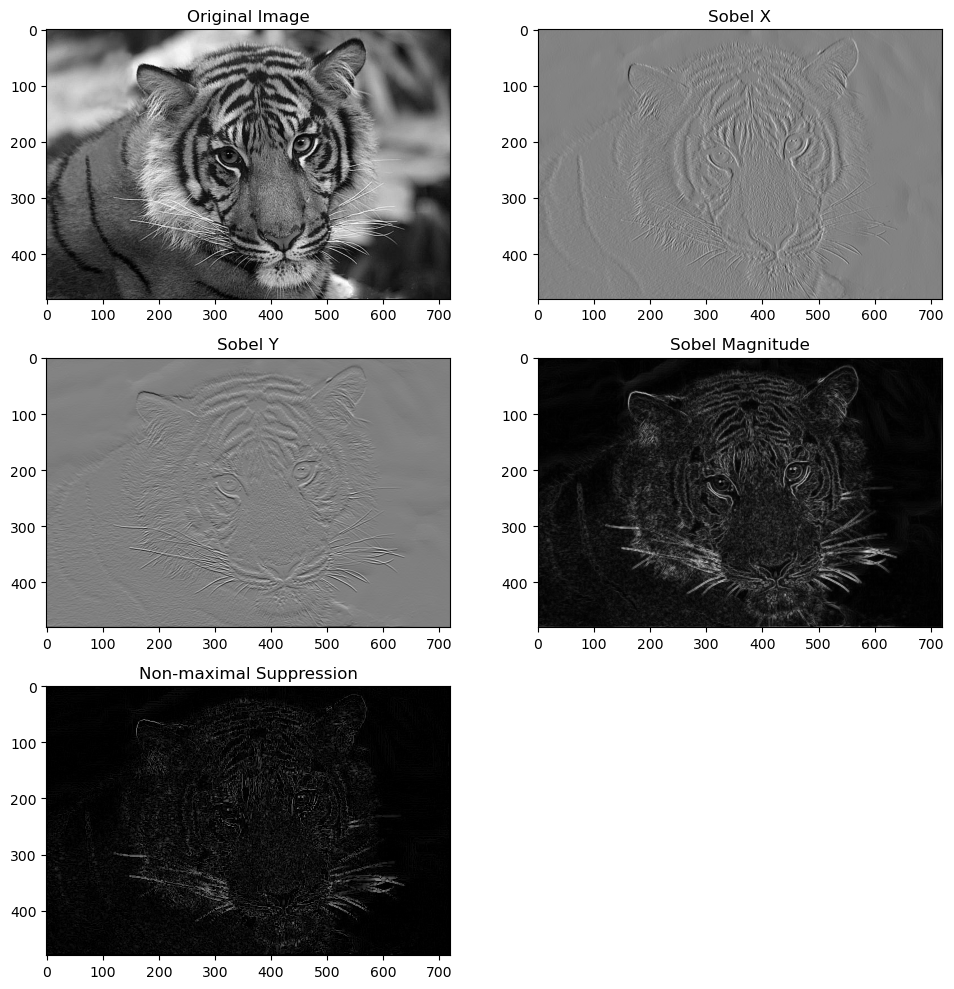

In [5]:
# 이미지 불러오기
image = plt.imread("Tiger.jpg")
gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # RGB to grayscale

# Sobel 커널 정의
sobel_x = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]])

# 컨볼루션 수행
sobel_x_image = convolve2d(gray_image, sobel_x)
sobel_y_image = convolve2d(gray_image, sobel_y)

# 경계 강도 계산
sobel_magnitude = np.sqrt(sobel_x_image**2 + sobel_y_image**2)
sobel_angle = np.arctan2(sobel_y_image, sobel_x_image)

# Non-maximal suppression
nms = non_max_suppression(sobel_magnitude, sobel_angle)

# 결과 출력
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.title("Original Image")
plt.imshow(gray_image, cmap='gray')

plt.subplot(3, 2, 2)
plt.title("Sobel X")
plt.imshow(sobel_x_image, cmap='gray')

plt.subplot(3, 2, 3)
plt.title("Sobel Y")
plt.imshow(sobel_y_image, cmap='gray')

plt.subplot(3, 2, 4)
plt.title("Sobel Magnitude")
plt.imshow(sobel_magnitude, cmap='gray')

plt.subplot(3, 2, 5)
plt.title("Non-maximal Suppression")
plt.imshow(nms, cmap='gray')

plt.tight_layout()
plt.show()

**3) 얇아진 edge 영상에 대해 Hysteresis 알고리즘을 적용 후 최종 출력**

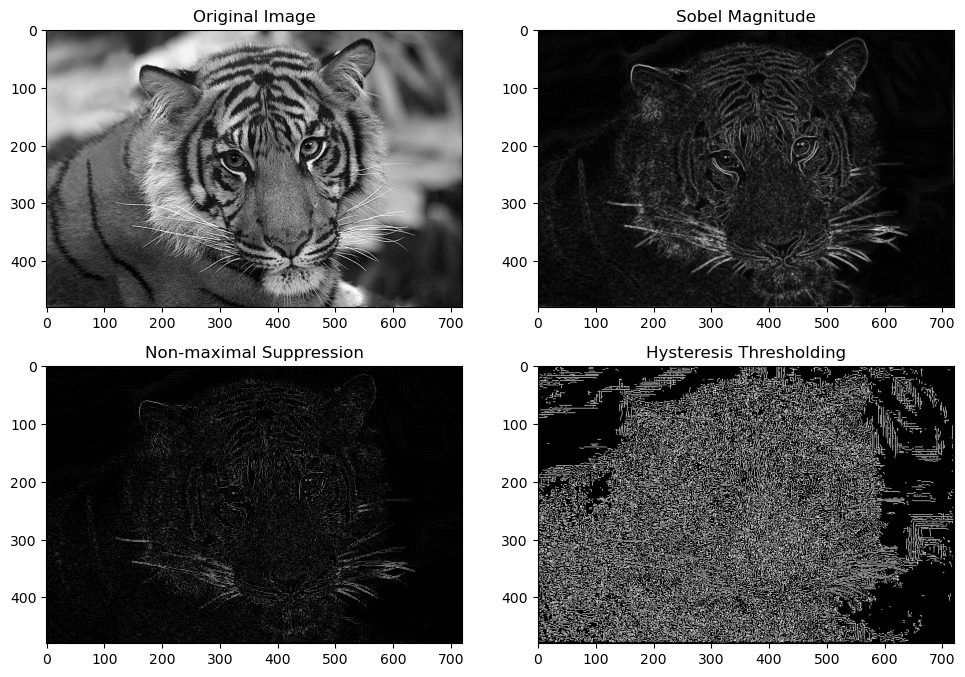

In [6]:
# Hysteresis thresholding
low = 20
high = 40
edge = hysteresis_threshold(nms, low, high)

# 결과 출력
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.title("Original Image")
plt.imshow(gray_image, cmap='gray')

plt.subplot(3, 2, 2)
plt.title("Sobel Magnitude")
plt.imshow(sobel_magnitude, cmap='gray')

plt.subplot(3, 2, 3)
plt.title("Non-maximal Suppression")
plt.imshow(nms, cmap='gray')

plt.subplot(3, 2, 4)
plt.title("Hysteresis Thresholding")
plt.imshow(edge, cmap='gray')

plt.tight_layout()
plt.show()

**4) Thresholding을 조정하며 유의미한 edge 남도록 실험**

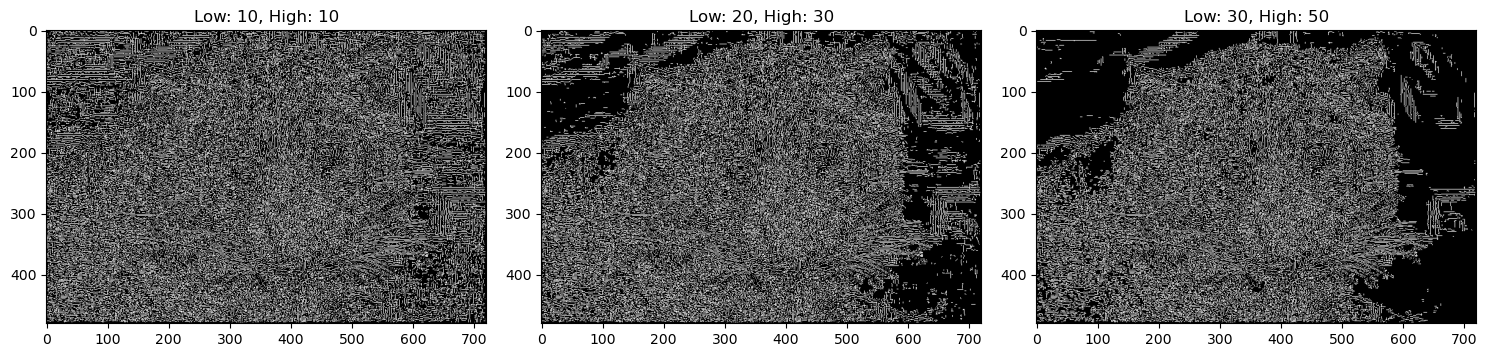

In [7]:
# Hysteresis thresholding
low_values = [10, 20, 30]
high_values = [10, 30, 50]

plt.figure(figsize=(15, 15))

for i, (low, high) in enumerate(zip(low_values, high_values)):
    edge = hysteresis_threshold(nms, low, high)

    plt.subplot(3, 3, i+1)
    plt.title(f'Low: {low}, High: {high}')
    plt.imshow(edge, cmap='gray')

plt.tight_layout()
plt.show()

# 2. 1번 문제에서 획득한 Edge 영상에 대해 Boundary tracing을 수행하여 오브젝트 경계 검출

- 입출력 부분 외 3rd party library 사용 금지  

위와 같은 조건이 있지만 OpenCV 아니면 경계 검출이 안돼서 일단 OpenCV를 사용하여 진행하였다.

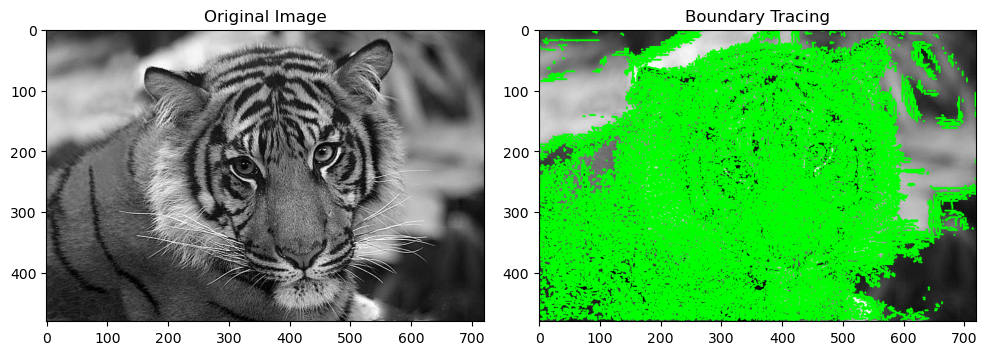

In [8]:
import cv2

# edge 이미지를 uint8으로 변환
edge = edge.astype(np.uint8)

# edge 이미지를 바이너리 이미지로 변환
_, binary = cv2.threshold(edge, 50, 255, cv2.THRESH_BINARY)

# 바이너리 이미지에서 윤곽 찾기
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 윤곽 그리기
output = cv2.cvtColor(gray_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.drawContours(output, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Boundary Tracing")
plt.imshow(output, cmap='gray')

plt.tight_layout()
plt.show()

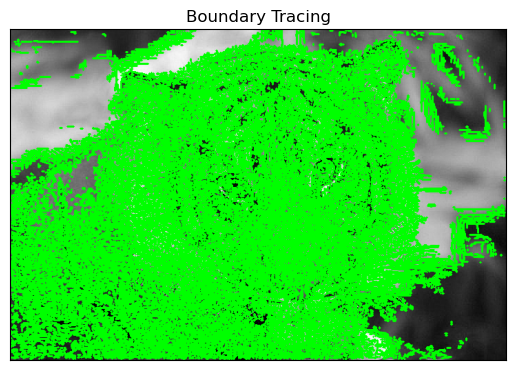

In [9]:
# Boundary Tracing 결과 저장

plt.title("Boundary Tracing")
plt.imshow(output, cmap='gray')

plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.savefig("output_tiger")
plt.show()